In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
%matplotlib inline
import ase


In [4]:
def osamples(n_samples=1):
    nfpa = np.random.normal(loc=26.42496428571428, scale=0.7598622819300876, size=n_samples)
    nfpa=np.round(nfpa).astype(int)
    gafpa=nfpa*16/28
    gafpa=np.round(gafpa).astype(int)
    ofpa=nfpa-gafpa
    return ofpa[0], gafpa[0]
print(osamples())
#38.757275 1.5456876137742062
def gasamples(n_samples=1):
    nfpa = np.random.normal(loc=38.757275, scale=1.5456876137742062, size=n_samples)
    nfpa=np.round(nfpa).astype(int)
    gafpa=nfpa*30/40
    gafpa=np.round(gafpa).astype(int)
    ofpa=nfpa-gafpa
    return ofpa[0], gafpa[0]
print(gasamples())
def spherical_to_cartesian(r, phi, theta):
    """ convert spherical coordinates (physics convention) to cart. vector
        input angles in DEGREES! """
    phi = np.deg2rad(phi)
    theta = np.deg2rad(theta)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return np.array([x, y, z])

def random_direction(seed=None):
    """ generate random direction in spherical coordinates """
    np.random.seed(seed)  # when None, seeds from /dev/urandom if available, else clock
    theta = np.arccos(2.0 * np.random.random() - 1)
    phi = 2.0 * np.random.random() * np.pi
    theta = np.rad2deg(theta)
    phi = np.rad2deg(phi)
    return phi, theta

(12, 15)
(10, 31)


In [5]:
# Sample DataFrame setup (replace this with your actual DataFrame)
# Assuming df is already created with columns ['Particle Identifier', 'Particle Type', 'x', 'y', 'z']

# Function to select sparse points
def select_sparse_points(df, n, min_distance=30):
    selected_indices = []
    attempts = 0  # To prevent infinite loops
    while len(selected_indices) < n and attempts < 1000:
        random_index = np.random.choice(df.index)
        selected_point = df.loc[random_index]

        # Check if this point is sufficiently far from already selected points
        if all(np.linalg.norm(selected_point[['x', 'y', 'z']].values - df.loc[i, ['x', 'y', 'z']].values) >= min_distance for i in selected_indices):
            selected_indices.append(random_index)

        attempts += 1

    return df.loc[selected_indices]

def displacement(fpas,xlo, xhi, ylo, yhi, zlo, zhi):
    """
    This function takes a DataFrame `fpas` and applies a random displacement 
    directly to the `x`, `y`, and `z` coordinates of each particle. If a displaced 
    position goes outside the box boundaries, it is wrapped back inside using 
    periodic boundary conditions.
    """
    # Reset the index to ensure we have a sequential numeric index
    fpas = fpas.reset_index(drop=True)
    # Box dimensions
    x_length = xhi - xlo
    y_length = yhi - ylo
    z_length = zhi - zlo
    for j in range(fpas.shape[0]):
        # Generate a random displacement distance within a specific range
        r = np.random.uniform(5.8, 6.2)
        
        # Generate random spherical coordinates for direction
        phi, theta = random_direction()
        
        # Convert spherical coordinates to Cartesian displacements
        displace_x, displace_y, displace_z = spherical_to_cartesian(r, phi, theta)
        # Calculate new positions with displacement
        new_x = fpas.at[j, 'x'] + displace_x
        new_y = fpas.at[j, 'y'] + displace_y
        new_z = fpas.at[j, 'z'] + displace_z
        
        # Apply periodic boundary conditions for each axis
        if new_x < xlo:
            new_x += x_length
        elif new_x > xhi:
            new_x -= x_length
            
        if new_y < ylo:
            new_y += y_length
        elif new_y > yhi:
            new_y -= y_length
            
        if new_z < zlo:
            new_z += z_length
        elif new_z > zhi:
            new_z -= z_length
        
        # Update the DataFrame with the new wrapped positions
        fpas.at[j, 'x'] = new_x
        fpas.at[j, 'y'] = new_y
        fpas.at[j, 'z'] = new_z

    return fpas
def apply_displacement_to_df(df, ofpas):
    """
    Apply the updated positions from `ofpas` to the corresponding atoms in `df`.
    
    Parameters:
        df (pd.DataFrame): The original DataFrame containing all atoms.
        ofpas (pd.DataFrame): The DataFrame containing the displaced atoms.
        
    Returns:
        pd.DataFrame: The modified DataFrame with updated positions.
    """
    for index, row in ofpas.iterrows():
        # Extract the Particle Identifier and the updated positions
        particle_id = row['Particle Identifier']
        new_x = row['x']  # Use the updated position
        new_y = row['y']
        new_z = row['z']

        # Locate the corresponding atom in the original df using Particle Identifier
        atom_index = df[df['Particle Identifier'] == particle_id].index
        
        if len(atom_index) > 0:  # Ensure the atom is found
            # Update the positions in df
            df.at[atom_index[0], 'x'] = new_x
            df.at[atom_index[0], 'y'] = new_y
            df.at[atom_index[0], 'z'] = new_z
            

    return df

In [31]:
import re

# Path to the LAMMPS data file
datafile = '/Users/ruhe/Desktop/ga2o3/beta/fpa_mic_overlap/data.lastframe_90'

# Initialize variables for the box dimensions
xlo, xhi, ylo, yhi, zlo, zhi = None, None, None, None, None, None

# Read through the file to find the box limits
with open(datafile, 'r') as file:
    for line in file:
        # Search for xlo xhi, ylo yhi, and zlo zhi lines using regex
        x_match = re.match(r"(-?\d+\.\d+)\s+(-?\d+\.\d+)\s+xlo xhi", line)
        y_match = re.match(r"(-?\d+\.\d+)\s+(-?\d+\.\d+)\s+ylo yhi", line)
        z_match = re.match(r"(-?\d+\.\d+)\s+(-?\d+\.\d+)\s+zlo zhi", line)
        
        if x_match:
            xlo, xhi = float(x_match.group(1)), float(x_match.group(2))
        elif y_match:
            ylo, yhi = float(y_match.group(1)), float(y_match.group(2))
        elif z_match:
            zlo, zhi = float(z_match.group(1)), float(z_match.group(2))

# Display extracted values
print("xlo:", xlo, "xhi:", xhi)
print("ylo:", ylo, "yhi:", yhi)
print("zlo:", zlo, "zhi:", zhi)


#datafile = '/home/heruhe/Desktop/Ga2o3/relaxed_dataframes/81920atoms.relaxed'
#reading all atoms final position
df=pd.read_csv(datafile, skiprows = 19, nrows=81920,sep="\s+",header=None)
print(df.describe())
df.columns=['Particle Identifier','Particle Type','x','y','z','p1','p2','p3']
df = df.apply(lambda col: pd.to_numeric(col, errors='coerce'))
npka=30
PKAs= select_sparse_points(df, npka, min_distance=30)
print(PKAs.shape)
lammps ='srun /projappl/djurabek/heru/lammps/build/lmp'

for ni in range(PKAs.shape[0]):
    PKA = PKAs.iloc[ni]
    #print(PKA)
    if PKA['Particle Type']<3:
        # Calculate radial distance
        dff = df[(np.sqrt((df['x'] - PKA['x'])**2 + 
                          (df['y'] - PKA['y'])**2 + 
                          (df['z'] - PKA['z'])**2) <= 15)]
    
        # Print the filtered DataFrame
        dffo=dff[dff['Particle Type']>2]
        dffga=dff[dff['Particle Type']<3]
        #print(len(dffga),len(dffo))
        nofpa,ngafpa=gasamples()
        #print(nofpa,ngafpa)
        ofpas=dffo.sample(n=nofpa, replace=False)
        #print(ofpas)
        gafpas=dffga.sample(n=ngafpa, replace=False)
        #print(gafpas)
        ofpas=displacement(ofpas,xlo, xhi, ylo, yhi, zlo, zhi)
        gafpas=displacement(gafpas,xlo, xhi, ylo, yhi, zlo, zhi)
        # Apply updated positions from ofpas to df
        df = apply_displacement_to_df(df, ofpas)
        # Apply updated positions from gafpas to df
        df = apply_displacement_to_df(df, gafpas)
        #print(ofpas)
        
    else:
        # Calculate radial distance
        dff = df[(np.sqrt((df['x'] - PKA['x'])**2 + 
                          (df['y'] - PKA['y'])**2 + 
                          (df['z'] - PKA['z'])**2) <= 30)]
    
        # Print the filtered DataFrame
        dffo=dff[dff['Particle Type']>2]
        dffga=dff[dff['Particle Type']<3]
        #print(len(dffga),len(dffo))
        nofpa,ngafpa=gasamples()
        #print(nofpa,ngafpa)
        ofpas=dffo.sample(n=nofpa, replace=False)
        #print(ofpas)
        gafpas=dffga.sample(n=ngafpa, replace=False)
        #print(gafpas)
        ofpas=displacement(ofpas,xlo, xhi, ylo, yhi, zlo, zhi)
        gafpas=displacement(gafpas,xlo, xhi, ylo, yhi, zlo, zhi)
        # Apply updated positions from ofpas to df
        df = apply_displacement_to_df(df, ofpas)
        # Apply updated positions from gafpas to df
        df = apply_displacement_to_df(df, gafpas)
print(df.describe())

xlo: -0.14382181802644567 xhi: 97.00039890169826
ylo: -0.14662306115980783 yhi: 98.8896929257671
zlo: -0.13968427372114434 zhi: 94.20983865391295
                  0             1             2             3             4  \
count  81920.000000  81920.000000  81920.000000  81920.000000  81920.000000   
mean   40960.500000      3.000000     48.371221     49.397341     47.062140   
std    23648.411363      1.414222     28.047301     28.595158     27.238752   
min        1.000000      1.000000     -0.143686     -0.146494     -0.139492   
25%    20480.750000      2.000000     24.135453     24.621128     23.443617   
50%    40960.500000      3.000000     48.408893     49.376334     47.043944   
75%    61440.250000      4.000000     72.706035     74.127545     70.618261   
max    81920.000000      5.000000     97.000321     98.889644     94.209761   

             5        6        7  
count  81920.0  81920.0  81920.0  
mean       0.0      0.0      0.0  
std        0.0      0.0      0.0  
mi

In [32]:
def write_lammps_data_file(df, box_dimensions, output_file):
    """
    Write a LAMMPS data file with updated positions from the DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing updated atom positions.
        box_dimensions (tuple): The dimensions of the box (xlo, xhi, ylo, yhi, zlo, zhi).
        output_file (str): The path to the output LAMMPS data file.
    """
    xlo, xhi, ylo, yhi, zlo, zhi = box_dimensions

    with open(output_file, 'w') as f:
        # Header
        f.write("LAMMPS data file via write_data, version 3 Aug 2022\n\n")
        f.write(f"{len(df)} atoms\n")
        f.write("5 atom types\n\n")
        f.write(f"{xlo} {xhi} xlo xhi\n")
        f.write(f"{ylo} {yhi} ylo yhi\n")
        f.write(f"{zlo} {zhi} zlo zhi\n\n")
        
        # Masses
        f.write("Masses\n\n")
        f.write("1 69.723\n")
        f.write("2 69.723\n")
        f.write("3 15.999\n")
        f.write("4 15.999\n")
        f.write("5 15.999\n\n")
        
        # Atoms
        f.write("Atoms # atomic\n\n")
        for index, row in df.iterrows():
            f.write(f"{int(row['Particle Identifier'])} {int(row['Particle Type'])} "
                     f"{row['x']} {row['y']} {row['z']} 0 0 0\n")

# Example usage
output_file = '/Users/ruhe/Desktop/ga2o3/beta/fpa_mic_overlap/data.lastframe_120'
box_dimensions = (xlo, xhi, ylo, yhi, zlo, zhi)  # You should define these dimensions
write_lammps_data_file(df, box_dimensions, output_file)

In [ ]:
def writeLmpIn(locout, npka, ofpas, gafpas, name="default_name", remote="no", time=1000):
    """
    Write an input file for LAMMPS.
    
    Parameters:
    locout: str
        Output path for the input file.
    npka: int
        Number of PKA (Primary Knock-on Atoms).
    ofpas: DataFrame
        DataFrame containing information about the first set of PKA.
    gafpas: DataFrame
        DataFrame containing information about the second set of PKA.
    name: str, optional
        Name string for the simulation (default is 'default_name').
    remote: str, optional
        Indicates whether to use remote paths for potential files (default is 'no').
    time: int, optional
        Total time step for the simulation (default is 1000).
    """
    
    with open(locout, "w") as wt:
        # Write basic simulation parameters
        wt.write("variable \t name string '%s' \n" % name)
        wt.write("\n")
        wt.write("units \t metal \n")
        wt.write("atom_style	 \t atomic \n")
        wt.write("boundary \t p p p \n")
        wt.write("neighbor \t 2.0 bin \n")
        wt.write("neigh_modify \t delay 0 every 1 check yes \n")
        wt.write("\n")
        
        # Log and data input
        wt.write("log \t log.${npka} \n")
        wt.write("\n")
        wt.write("read_data data.beta_last \n")
        wt.write("\n")
        
        # Define masses for atom types
        wt.write("mass 1 69.723\n")
        wt.write("mass 2 69.723\n")
        wt.write("mass 3 15.9994\n")
        wt.write("mass 4 15.9994\n")
        wt.write("mass 5 15.9994\n")
        wt.write("\n")
        
        # Define pair styles and coefficients
        wt.write("pair_style	 \t hybrid/overlay eam/fs tabgap \n")
        if remote == "no":
            wt.write("pair_coeff	 \t * * eam/fs /home/heruhe/Desktop/Ga2o3/potential/Ga-O_20220921.eam.fs Ga Ga O O O \n")
            wt.write("pair_coeff	 \t * * tabgap /home/heruhe/Desktop/Ga2o3/potential/Ga-O_20220921.tabgap Ga Ga O O O no yes \n")
        elif remote == "yes":
            wt.write("pair_coeff	 \t * * eam/fs /scratch/djurabek/heru/ga2o3/potential/Ga-O_20220921.eam.fs Ga Ga O O O \n")
            wt.write("pair_coeff	 \t * * tabgap /scratch/djurabek/heru/ga2o3/potential/Ga-O_20220921.tabgap Ga Ga O O O no yes \n")
        else:
            raise ValueError("The remote parameter should be either 'yes' or 'no'.")
        
        wt.write("\n")
        
        # Define thermodynamic variables
        wt.write("variable	 \t ape equal pe/atoms \n")
        wt.write("variable	 \t ake equal ke/atoms \n")
        wt.write("variable	 \t avol equal vol/atoms \n")
        wt.write("compute	 \t ep all pe/atom \n")
        wt.write("compute	 \t ek all ke/atom \n")
        wt.write("\n")

        # Thermo settings
        wt.write("thermo	 \t 100 \n")
        wt.write("thermo_style \t custom step dt time temp press v_ape v_ake etotal pxx pyy pzz lx ly lz v_avol \n")
        wt.write("thermo_style \t lost warn line one flush yes format 1 \"ec %8lu\" format float \"%14.10g\" \n")
        wt.write("\n")

        # Loop through `ofpas` DataFrame to write PKA displacements
        for i in range(ofpas.shape[0]):
            PKAID = ofpas.iloc[i]['Particle Identifier']
            dis_x = ofpas.iloc[i]['displace_x']
            dis_y = ofpas.iloc[i]['displace_y']
            dis_z = ofpas.iloc[i]['displace_z']
            wt.write("\n")
            wt.write(f"group fp id {PKAID}\n")  # Using f-string for clarity
            wt.write(f"displace_atoms fp move {dis_x} {dis_y} {dis_z}\n")
        
        # Loop through `gafpas` DataFrame to write additional PKA displacements
        for i in range(gafpas.shape[0]):
            PKAID = gafpas.iloc[i]['Particle Identifier']
            dis_x = gafpas.iloc[i]['displace_x']
            dis_y = gafpas.iloc[i]['displace_y']
            dis_z = gafpas.iloc[i]['displace_z']
            wt.write("\n")
            wt.write(f"group fp id {PKAID}\n")  # Using f-string for clarity
            wt.write(f"displace_atoms fp move {dis_x} {dis_y} {dis_z}\n")
        
        # Final commands for simulation
        wt.write("min_style \t cg \n")
        wt.write("minimize \t 1e-5 1e-6 10000 10000 \n")
        wt.write("\n")
        wt.write("velocity \t all create 600 666 mom yes rot yes dist gaussian units box \n")
        wt.write("fix \t 1 all npt temp 300 300 0.1 aniso 0.0 0.0 1.0 \n")
        wt.write(f"dump  mydump all custom 100 dumpfiles/dump._{npka} id type x y z c_ep c_ek \n")
        wt.write("timestep \t 0.002 \n")
        wt.write(f"run \t {time}\n")
        wt.write("\n")
        wt.write(f"write_data \t out/data.lastframe_{npka}\n")
        wt.write("write_data \t data.beta_last\n")


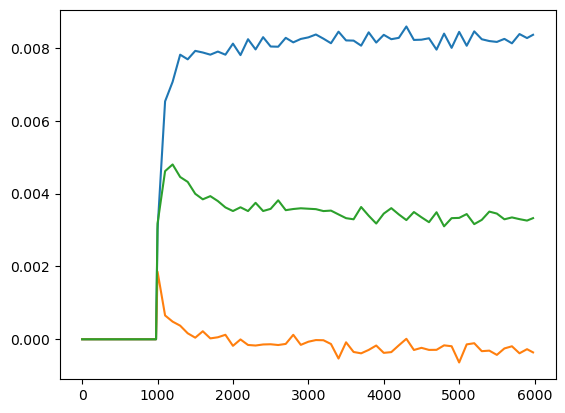

In [38]:
import lammps_logfile
fn='/Users/ruhe/Desktop/ga2o3/beta/fpa_mic_overlap/log.30'

log = lammps_logfile.File(fn)
plt.plot(log.get('Step'),(log.get("Lx")-log.get("Lx")[0])/log.get("Lx")[0])
plt.plot(log.get('Step'),(log.get("Ly")-log.get("Ly")[0])/log.get("Ly")[0])
plt.plot(log.get('Step'),(log.get("Lz")-log.get("Lz")[0])/log.get("Lz")[0])
